In [1]:
!pip install -U -qq datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
from torchvision.transforms.functional import InterpolationMode
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Helper Functions


In [10]:
def imshow(img, one_channel=False):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # denormalize
    img = np.clip(img, 0, 1)  # ensure img values are within [0, 1]
    if one_channel:
        img = img.mean(axis=2)
    plt.imshow(img)
    plt.show()

def show_images(dataset, num_images=4):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(dataloader))  # Get a batch of images

    # Create a grid of images
    img_grid = make_grid(images)

    # Show images and label
    imshow(img_grid)
    print('Labels:', labels)

## Model & Data Setup

In [4]:
# Load the pretrained model
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)
# Use the provided preprocessing steps from the weights
#weights = ViT_B_16_Weights.IMAGENET1K_V1
#ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()
#preprocess = weights.transforms()
ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms() # The transforms provided for the model

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:08<00:00, 41.2MB/s]


ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [5]:
# Modified transform functions, some augmentation is added in train_preprocess
train_preprocess = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert grayscale to RGB if needed
    transforms.Resize((384,384), interpolation=InterpolationMode.BICUBIC),  # Resize the image to 256x256
    #transforms.CenterCrop(384),  # Crop the image to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, and saturation
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Random affine transformation
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

test_preprocess = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert grayscale to RGB if needed
    transforms.Resize((384,384), interpolation=InterpolationMode.BICUBIC),
    #transforms.CenterCrop(384),
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])


# Freeze all parameters in the model, since we will use it as a feature extractor
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last encoder layer
for param in model.encoder.layers.encoder_layer_11.parameters():
    param.requires_grad = True

# Replace the head of the model with a new one for fine-tuning
model.heads.head = nn.Linear(model.heads.head.in_features, 200)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);


In [6]:
def count_trainable_params(model):
    # Count the number of parameters that require gradients (are trainable)
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the trainable parameters
num_trainable_params = count_trainable_params(model)
print(f"Number of trainable parameters: {num_trainable_params}")

Number of trainable parameters: 7241672


### Load CUB Dataset

In [7]:
#dataset = load_dataset('AI-Lab-Makerere/beans')
dataset = load_dataset('efekankavalci/CUB_200_2011')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5994 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5794 [00:00<?, ? examples/s]

In [8]:
import torch
from torch.utils.data import Subset
import random

class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None, indices=None):
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.indices = list(range(len(hf_dataset))) if indices is None else indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]
        item = self.hf_dataset[true_idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Function that creates a balanced validation set
def create_balanced_split(dataset, train_transform=None, val_transform=None, num_samples_per_class=5):
    label_to_indices = {}

    for index in range(len(dataset.hf_dataset)):
        item = dataset.hf_dataset[index]
        label = item['label']

        if label in label_to_indices:
            label_to_indices[label].append(index)
        else:
            label_to_indices[label] = [index]

    train_indices = []
    validation_indices = []

    for label, indices in label_to_indices.items():
        if len(indices) >= num_samples_per_class:
            chosen_indices = random.sample(indices, num_samples_per_class)
            validation_indices.extend(chosen_indices)
            train_indices.extend([idx for idx in indices if idx not in chosen_indices])
        else:
            # If there are not enough samples, use them all for validation
            validation_indices.extend(indices)

    # Create subset datasets
    # validation_set = Subset(dataset, validation_indices)
    validation_set = HFDataset(dataset.hf_dataset, transform=val_transform, indices=validation_indices)
    train_set = HFDataset(dataset.hf_dataset, transform = train_transform, indices=train_indices)
    return train_set, validation_set

#train_dataset, validation_dataset = create_balanced_split(
#    dataset=HFDataset(dataset['train']),
#    train_transform=train_preprocess,
#    val_transform=test_preprocess,
#    num_samples_per_class=5
#)
train_dataset = HFDataset(dataset['train'], transform=train_preprocess)
test_dataset = HFDataset(dataset['test'], transform=test_preprocess)

In [ ]:
# Check the train-val split
len(train_dataset), len(validation_dataset), len(test_dataset)

(4994, 1000, 5794)

In [21]:
bs = 128 # batch size
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
#val_loader = DataLoader(validation_dataset, batch_size=bs, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

### Observe images

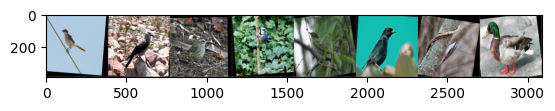

Labels: tensor([110,  92, 173,  72, 178,  26,  27,  86])


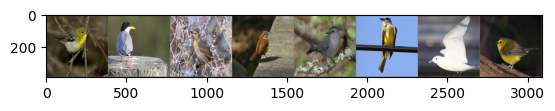

Labels: tensor([156, 146, 171, 194,  18,  76,  62, 166])


In [11]:
# observe some images
show_images(train_dataset, num_images=8)
show_images(test_dataset, num_images=8)

## Training

In [12]:
def validate_model(model, val_loader, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def load_checkpoint(epoch, model, optimizer, scheduler, base_path):
    checkpoint_path = f"{base_path}{epoch}_checkpoint.pth"
    losses_path = f"{base_path}{epoch}_losses.json"
    lr_path = f"{base_path}{epoch}_lr.json"
    val_accuracies_path = f"{base_path}{epoch}_val_accuracies.json"
    val_losses_path = f"{base_path}{epoch}_val_losses.json"

    # Load the model, optimizer, and scheduler states
    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    # Load losses and other metrics
    with open(losses_path, 'r') as f:
        losses = json.load(f)
    with open(lr_path, 'r') as f:
        lr = json.load(f)
    with open(val_accuracies_path, 'r') as f:
        val_accuracies = json.load(f)
    with open(val_losses_path, 'r') as f:
        val_losses = json.load(f)

    return {
        'model': model,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'losses': losses,
        'learning_rate': lr,
        'validation_accuracies': val_accuracies,
        'validation_losses': val_losses
    }


In [13]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.01)  # Optimize only the head
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.2, total_iters=25, )

In [ ]:
# If we are loading from checkponit to continue training
checkpoint = load_checkpoint(24, model, optimizer, scheduler, '/content/drive/MyDrive/CMPE_DL_for_CV_Project/fine_tuning/ViT_B_16_IMAGENET1K_SWAG_E2E_V1_batch_size_128_encoder11_weight_decay_0.01/epoch')

In [ ]:
model = checkpoint['model']
optimizer = checkpoint['optimizer']
scheduler = checkpoint['scheduler']
losses = checkpoint['losses']
lr = checkpoint['learning_rate']
val_accuracies = checkpoint['validation_accuracies']
val_losses = checkpoint['validation_losses']

In [ ]:
losses = []
lr = []
train_accuracies = []
val_accuracies = []
val_losses= []

In [ ]:
# Training loop
num_epochs = 34
for epoch in range(30,34):
    model.train()  # Set model to training mode
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        lr.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)


    val_accuracy = validate_model(model, val_loader, device)
    val_accuracies.append(val_accuracy)
    print(f'Validation Accuracy after epoch {epoch+1}: {val_accuracy:.4f}%')
    #train_accuracy = validate_model(model, train_loader, device)
    #print(f'Training Accuracy after epoch {epoch+1}: {train_accuracy:.4f}%')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


    path_epoch = '/content/drive/MyDrive/CMPE_DL_for_CV_Project/fine_tuning/ViT_B_16_IMAGENET1K_SWAG_E2E_V1_batch_size_128_encoder11_weight_decay_0.01/epoch' + str(epoch + 1)
    # Save model and scheduler state
    if (epoch + 1) % 2 == 0:
      torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict()
      }, path_epoch + '_checkpoint.pth')

      with open(path_epoch + '_losses.json', 'w') as f:
        json.dump(losses, f)
      with open(path_epoch + '_lr.json', 'w') as f:
        json.dump(lr, f)
      with open(path_epoch + '_val_accuracies.json', 'w') as f:
        json.dump(val_accuracies, f)
      with open(path_epoch + '_val_losses.json', 'w') as f:
        json.dump(val_losses, f)



## Load and Plot Results

### Results with weight decay 0.001

In [25]:
epoch_number = 14
results = load_checkpoint(epoch_number, model, optimizer, scheduler,  '/content/drive/MyDrive/CMPE_DL_for_CV_Project/fine_tuning/ViT_B_16_IMAGENET1K_SWAG_E2E_V1_batch_size_128_encoder11/epoch')


In [26]:
train_accuracy = validate_model(results['model'], train_loader, device)
print(f'Training Accuracy after epoch {epoch_number}: {train_accuracy:.4f}%')

Training Accuracy after epoch 14: 95.7791%


In [27]:
test_accuracy = validate_model(results['model'], test_loader, device)
print(f'Test Accuracy after epoch {epoch_number}: {test_accuracy:.4f}%')

Test Accuracy after epoch 14: 84.0179%


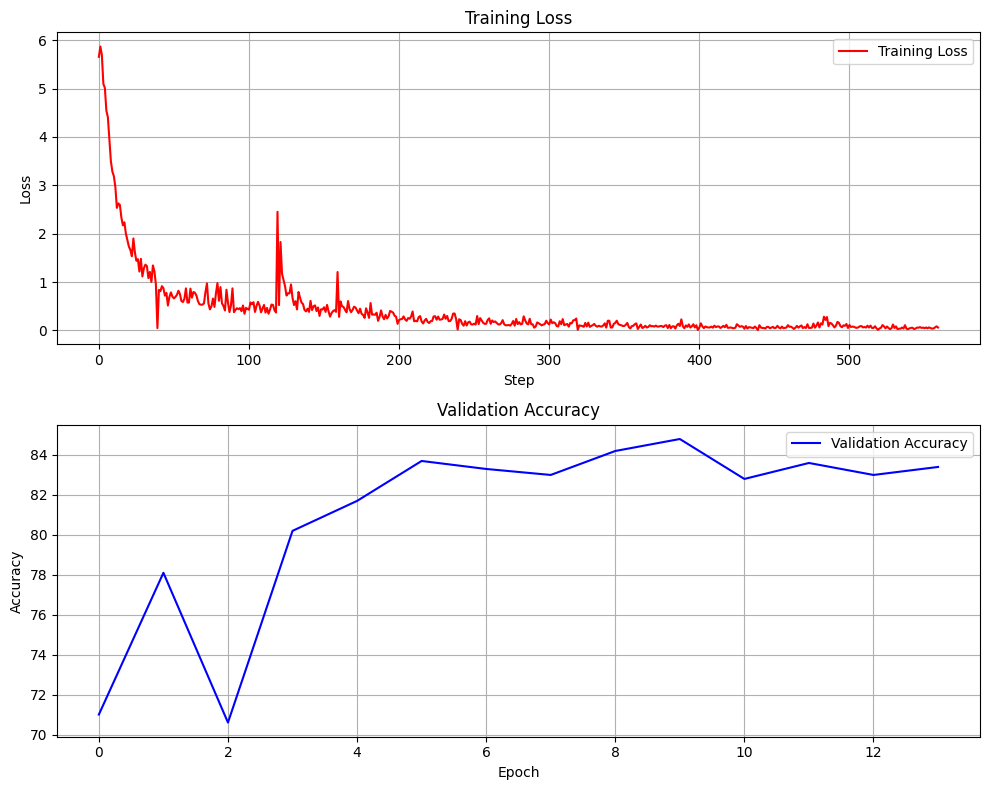

In [28]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

# Plotting training losses
axs[0].plot(results['losses'], label='Training Loss', color='red')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plotting validation accuracies
axs[1].plot(results['validation_accuracies'], label='Validation Accuracy', color='blue')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)
# Adjust layout
plt.tight_layout()


# Show the plot
plt.show()

### Results with weight decay 0.01

In [18]:
epoch_number = 24
results = load_checkpoint(epoch_number, model, optimizer, scheduler,  '/content/drive/MyDrive/CMPE_DL_for_CV_Project/fine_tuning/ViT_B_16_IMAGENET1K_SWAG_E2E_V1_batch_size_128_encoder11_weight_decay_0.01/epoch')


In [22]:
train_accuracy = validate_model(results['model'], train_loader, device)
print(f'Training Accuracy after epoch {epoch_number}: {train_accuracy:.4f}%')

Training Accuracy after epoch 24: 95.8125%


In [23]:
test_accuracy = validate_model(results['model'], test_loader, device)
print(f'Test Accuracy after epoch {epoch_number}: {test_accuracy:.4f}%')

Test Accuracy after epoch 24: 84.8637%


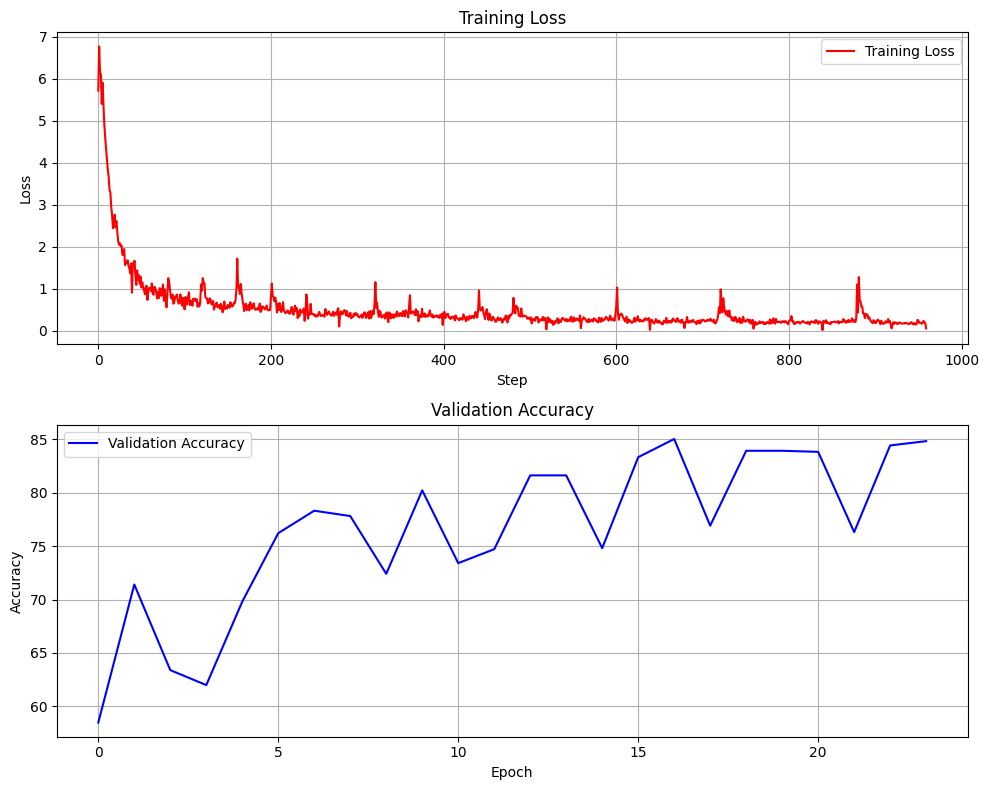

In [24]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

# Plotting training losses
axs[0].plot(results['losses'], label='Training Loss', color='red')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plotting validation accuracies
axs[1].plot(results['validation_accuracies'], label='Validation Accuracy', color='blue')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)
# Adjust layout
plt.tight_layout()


# Show the plot
plt.show()